# Time Series Forecasting

In this tutorial, we will demonstrate how to build a model for time series forecasting in NumPyro. Specifically, we will replicate the **Seasonal, Global Trend (SGT)** model from the [Rlgt: Bayesian Exponential Smoothing Models with Trend Modifications](https://cran.r-project.org/web/packages/Rlgt/index.html) package. The time series data that we will use for this tutorial is the **lynx** dataset, which contains annual numbers of lynx trappings from 1821 to 1934 in Canada.

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import set_matplotlib_formats

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(4)
assert numpyro.__version__.startswith("0.4.0")

## Data

First, lets import and take a look at the dataset.

Length of time series: 114


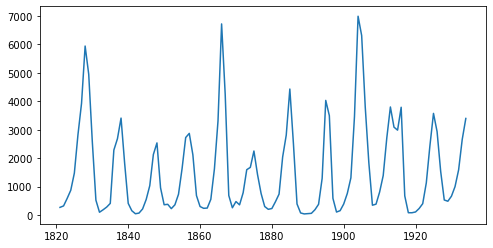

In [2]:
URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/lynx.csv"
lynx = pd.read_csv(URL, index_col=0)
data = lynx["value"].values
print("Length of time series:", data.shape[0])
plt.figure(figsize=(8, 4))
plt.plot(lynx["time"], data)
plt.show()

The time series has a length of 114 (a data point for each year), and by looking at the plot, we can observe [seasonality](https://en.wikipedia.org/wiki/Seasonality) in this dataset, which is the recurrence of similar patterns at specific time periods. e.g. in this dataset, we observe a cyclical pattern every 10 years, but there is also a less obvious but clear spike in the number of trappings every 40 years. Let us see if we can model this effect in NumPyro.

In this tutorial, we will use the first 80 values for training and the last 34 values for testing.

In [3]:
y_train, y_test = jnp.array(data[:80], dtype=jnp.float32), data[80:]

## Model

The model we are going to use is called **Seasonal, Global Trend**, which when tested on 3003 time series of the [M-3 competition](https://forecasters.org/resources/time-series-data/m3-competition/), has been known to outperform other models originally participating in the competition:

$$
\begin{align}
\text{exp_val}_{t} &= \text{level}_{t-1} + \text{coef_trend} \times \text{level}_{t-1}^{\text{pow_trend}} + \text{s}_t \times \text{level}_{t-1}^{\text{pow_season}}, \\
\sigma_{t} &= \sigma \times \text{exp_val}_{t}^{\text{powx}} + \text{offset}, \\
y_{t} &\sim \text{StudentT}(\nu, \text{exp_val}_{t}, \sigma_{t})
\end{align}
$$

, where `level` and `s` follows the following recursion rules:

$$
\begin{align}
\text{level_p} &=
\begin{cases}
y_t - \text{s}_t \times \text{level}_{t-1}^{\text{pow_season}} & \text{if } t \le \text{seasonality}, \\ 
\text{Average} \left[y(t - \text{seasonality} + 1), \ldots, y(t)\right] & \text{otherwise},
\end{cases} \\
\text{level}_{t} &= \text{level_sm} \times \text{level_p} + (1 - \text{level_sm}) \times \text{level}_{t-1}, \\
\text{s}_{t + \text{seasonality}} &= \text{s_sm} \times \frac{y_{t} - \text{level}_{t}}{\text{level}_{t-1}^{\text{pow_trend}}}
+ (1 - \text{s_sm}) \times \text{s}_{t}.
\end{align}
$$

A more detailed explanation for SGT model can be found in [this vignette](https://cran.r-project.org/web/packages/Rlgt/vignettes/GT_models.html) from the authors of the Rlgt package. Here we summarize the core ideas of this model:

+ [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), which has heavier tails than normal distribution, is used for the likelihood.
+ The expected value `exp_val` consists of a trending component and a seasonal component:
  - The trend is governed by the map $x \mapsto x + ax^b$, where $x$ is `level`, $a$ is `coef_trend`, and $b$ is `pow_trend`. Note that when $b \sim 0$, the trend is linear with $a$ is the slope, and when $b \sim 1$, the trend is exponential with $a$ is the rate. So that function can cover a large family of trend.
  - When time changes, `level` and `s` are updated to new values. Coefficients `level_sm` and `s_sm` are used to make the transition smoothly.
+ When `powx` is near $0$, the error $\sigma_t$ will be nearly constant while when `powx` is near $1$, the error will be propotional to the expected value.
+ There are several varieties of SGT. In this tutorial, we use generalized seasonality and seasonal average method.

We are ready to specify the model using *NumPyro* primitives. In NumPyro, we use the primitive `sample(name, prior)` to declare a latent random variable with a corresponding `prior`. These primitives can have custom interpretations depending on the effect handlers that are used by NumPyro inference algorithms in the backend. e.g. we can condition on specific values using the `condition` handler, or record values at these sample sites in the execution trace using the `trace` handler. Note that these details are not important for specifying the model, or running inference, but curious readers are encouraged to read the [tutorial on effect handlers](http://pyro.ai/examples/effect_handlers.html) in Pyro.

In [4]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level ** pow_season
        exp_val = level + coef_trend * level ** pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val ** powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

Note that `level` and `s` are updated recursively while we collect the expected value at each time step. NumPyro uses [JAX](https://github.com/google/jax) in the backend to JIT compile many critical parts of the NUTS algorithm, including the verlet integrator and the tree building process. However, doing so using Python's `for` loop in the model will result in a long compilation time for the model, so we use `scan` - which is a wrapper of [lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html#jax.lax.scan) with supports for NumPyro primitives and handlers. A detailed explanation for using this utility can be found in [NumPyro documentation](http://num.pyro.ai/en/latest/primitives.html#scan). Here we use it to collect `y` values while the triple `(level, s, moving_sum)` plays the role of carrying state.

Another note is that instead of declaring the observation site `y` in `transition_fn`

```python
numpyro.sample("y", dist.StudentT(nu, exp_val, omega), obs=y[t])
```

, we have used [condition](http://num.pyro.ai/en/stable/handlers.html#numpyro.handlers.condition) handler here. The reason is we also want to use this model for forecasting. In forecasting, future values of `y` are non-observable, so `obs=y[t]` does not make sense when `t >= len(y)` (caution: index out-of-bound errors do not get raised in JAX, e.g. `jnp.arange(3)[10] == 2`). Using `condition`, when the length of `scan` is larger than the length of the conditioned/observed site, unobserved values will be sampled from the distribution of that site.

## Inference

First, we want to choose a good value for `seasonality`. Following [the demo in Rlgt](https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/demo/lynx.R), we will set `seasonality=38`. Indeed, this value can be guessed by looking at the plot of the training data, where the second order seasonality effect has a periodicity around $40$ years. Note that $38$ is also one of the highest-autocorrelation lags.

In [5]:
print("Lag values sorted according to their autocorrelation values:\n")
print(jnp.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[ 0 67 57 38 68  1 29 58 37 56 28 10 19 39 66 78 47 77  9 79 48 76 30 18
 20 11 46 59 69 27 55 36  2  8 40 49 17 21 75 12 65 45 31 26  7 54 35 41
 50  3 22 60 70 16 44 13  6 25 74 53 42 32 23 43 51  4 15 14 34 24  5 52
 73 64 33 71 72 61 63 62]


Now, let us run $4$ MCMC chains (using the No-U-Turn Sampler algorithm) with $5000$ warmup steps and $5000$ sampling steps per each chain. The returned value will be a collection of $20000$ samples.

In [6]:
%%time
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=4)
mcmc.run(random.PRNGKey(0), y_train, seasonality=38)
mcmc.print_summary()
samples = mcmc.get_samples()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     32.33    123.99     12.07    -91.43    157.37   1307.74      1.00
       init_s[0]     84.35    105.16     61.08    -59.71    232.37   4053.35      1.00
       init_s[1]    -21.48     72.05    -26.11   -130.13     94.34   1038.51      1.01
       init_s[2]     26.08     92.13     13.57   -114.83    156.16   1559.02      1.00
       init_s[3]    122.52    123.56    102.67    -59.39    305.43   4317.17      1.00
       init_s[4]    443.91    254.12    395.89     69.08    789.27   3090.34      1.00
       init_s[5]   1163.56    491.37   1079.23    481.92   1861.90   1562.40      1.00
       init_s[6]   1968.70    649.68   1860.04    902.00   2910.49   1974.42      1.00
       init_s[7]   3652.34   1107.27   3505.37   1967.67   5383.26   1669.91      1.00
       init_s[8]   2593.04    831.42   2452.27   1317.67   3858.55   1805.87      1.00
       init_s[9]    947.28    422.29    88

## Forecasting

Given `samples` from `mcmc`, we want to do forecasting for the testing dataset `y_test`. NumPyro provides a convenient utility [Predictive](http://num.pyro.ai/en/stable/utilities.html#numpyro.infer.util.Predictive) to get predictive distribution. Let's see how to use it to get forecasting values.

Notice that in the `sgt` model defined above, there is a keyword `future` which controls the execution of the model - depending on whether `future > 0` or `future == 0`. The following code predicts the last 34 values from the original time-series.

In [7]:
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=38, future=34)[
    "y_forecast"
]

Let's get sMAPE, root mean square error of the prediction, and visualize the result with the mean prediction and the 90% highest posterior density interval (HPDI).

In [8]:
y_pred = jnp.mean(forecast_marginal, axis=0)
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 63.93, rmse: 1249.29


Finally, let's plot the result to verify that we get the expected one.

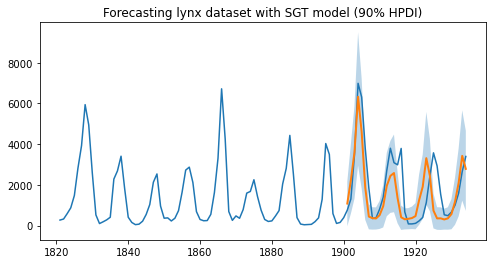

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(lynx["time"], data)
t_future = lynx["time"][80:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting lynx dataset with SGT model (90% HPDI)")
plt.show()

As we can observe, the model has been able to learn both the first and second order seasonality effects, i.e. a cyclical pattern with a periodicity of around 10, as well as spikes that can be seen once every 40 or so years. Moreover, we not only have point estimates for the forecast but can also use the uncertainty estimates from the model to bound our forecasts. 

## Acknowledgements

We would like to thank Slawek Smyl for many helpful resources and suggestions. Fast inference would not have been possible without the support of JAX and the XLA teams, so we would like to thank them for providing such a great open-source platform for us to build on, and for their responsiveness in dealing with our feature requests and bug reports.

## References

[1] `Rlgt: Bayesian Exponential Smoothing Models with Trend Modifications`,<br>&nbsp;&nbsp;&nbsp;&nbsp;
Slawek Smyl, Christoph Bergmeir, Erwin Wibowo, To Wang Ng, Trustees of Columbia University